average speed is:  0.0351485290086455
             x         y         z  velocity_x  velocity_y  filtered_x  \
100  -0.032347 -0.003363 -0.002809   -0.009607    0.000959   -0.040345   
101  -0.004157 -0.005707 -0.010303    0.000000    0.000000   -0.016314   
102  -0.011444 -0.019933 -0.017723    0.000000    0.000000    0.002506   
103  -0.091944 -0.042272  0.023382    0.000000    0.000000   -0.069723   
104   0.088139 -0.047193  0.009128   -0.001293   -0.000105    0.005083   
105  -0.011069 -0.087174  0.013815    0.000000    0.000000    0.070692   
106  -0.071217 -0.114492  0.020857   -0.000251   -0.000362   -0.083219   
107  -0.046506 -0.093678  0.053851   -0.003150   -0.000954   -0.061778   
108  -0.084168 -0.100598  0.072165   -0.005388   -0.001860   -0.050077   
109  -0.095383 -0.134284  0.056898   -0.008727   -0.003157   -0.116918   
110  -0.249335 -0.168361  0.041087   -0.014517   -0.004909   -0.172548   
111  -0.409109 -0.187042  0.119643   -0.025690   -0.007173   -0.386129   


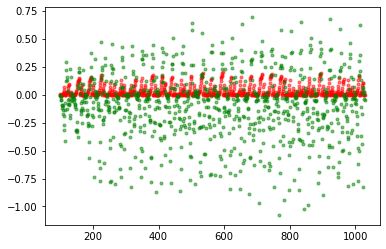

In [20]:
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from statsmodels.nonparametric.smoothers_lowess import lowess

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

df = pd.read_csv('new_foot_3.txt', sep=';', header=0)
df['velocity_x']=0
df['velocity_y']=0
df=df.shift(periods=1, axis=0, fill_value=0)

#df=df.drop(['Date', 'DeviceOrientation', 'Label'], axis=1)
#print(df)
df.columns=['time', 'x', 'y', 'z', 'velocity_x', 'velocity_y']
#print(df)
#df['acc']=np.sqrt((np.square(df['x']))+(np.square(df['y'])))
#df['acc']=df['y']/np.sin(np.pi/6)
#df['index']=df['index'].shift(-1, fill_value=df['index'].iloc[-1]+1)
#b, a = signal.butter(3, 0.1, btype='lowpass', analog=False)
#df['x']=df['x']*-1

sos_x = signal.butter(5, 0.9, 'lp', output='sos')
df['filtered_x'] = signal.sosfilt(sos_x, df['x'])
#smoothed= lowess(df['x'], df.index, frac=0.001) #smooth
#df['filtered_x']=smoothed[:, 1]

sos_y = signal.butter(3, 0.1, 'lp', output='sos')
df['filtered_y'] = signal.sosfilt(sos_y, df['y'])
#smoothed_y= lowess(df['y'], df.index, frac=0.01) #smooth
#df['filtered_y'] =smoothed_y[:, 1]

'''
#print(df)
merged = pd.concat([df[df['filtered_x']>=0], df[df['filtered_x']<0],df[df['filtered_y']>=0],df[df['filtered_y']>=0]], axis=1)

merged = merged.drop(['x', 'y', 'velocity_x', 'velocity_y', 'z', 'index'], axis=1)
merged.columns=['positive_x', 'positive_y', 'negative_x', 'negative_y', 'filtered_x', 'filtered_y', 'x', 'y']
merged = merged.drop(['x', 'y', 'positive_y', 'negative_y'], axis=1)
print(merged)
'''

def find_vol(df):
    row, col = df.shape
    for i in range (0, row-1):
        '''
        df.loc[df.index==i+1, 'velocity x'] = df.loc[i].at['velocity x']+(0.05*df.loc[i+1].at['x'])
        df.loc[df.index==i+1, 'velocity y'] = df.loc[i].at['velocity y']+(0.05*df.loc[i+1].at['y'])
        df.loc[df.index==i+1, 'velocity z'] = df.loc[i].at['velocity z']+(0.05*df.loc[i+1].at['z'])
        '''
        
        #if abs(df.loc[i].at['filtered_x']) <=0.008:
        if (df.loc[i].at['filtered_x'] * df.loc[i+1].at['filtered_x']) < 0:
            df.loc[df.index==i, 'velocity_x'] = 0
            df.loc[df.index==i, 'velocity_y'] = 0
        
        #df.loc[df.index==i+1, 'velocity_y'] = df.loc[i].at['velocity_y']+(0.04*df.loc[i+1].at['filtered_y'])
        #df.loc[df.index==i+1, 'velocity_x'] = df.loc[i].at['velocity_x']+(0.04*df.loc[i+1].at['filtered_x'])
        df.loc[df.index==i+1, 'velocity_x'] = (((df.loc[i+1].at['filtered_x']+df.loc[i].at['filtered_x'])/2)*0.04) + df.loc[i].at['velocity_x']
        df.loc[df.index==i+1, 'velocity_y'] = (((df.loc[i+1].at['filtered_y']+df.loc[i].at['filtered_y'])/2)*0.04) + df.loc[i].at['velocity_y']
        #acceleration.loc[acceleration.index == i,'xy_acc'] = np.sqrt((np.square(acceleration.loc[i].at["x"])+ np.square(acceleration.loc[i].at["y"])))
    return df
velocity_df = find_vol(df)
velocity_df = velocity_df.drop(['time'], axis=1)
velocity_df['angular_velocity']=np.sqrt(np.square(velocity_df['velocity_x']) + np.square(velocity_df['velocity_y']))

velocity_df.drop(velocity_df.index[0:100], 0, inplace=True)
velocity_df.drop(velocity_df.tail(140).index, inplace=True)


average_speed = velocity_df['angular_velocity'].sum() / (velocity_df.shape[0]) #m/s / s 1010 
print("average speed is: ",average_speed)
#velocity_df['angular velocity']=velocity_df['velocity_x'] + velocity_df['velocity_y']
print(velocity_df)
#velocity_df.to_csv('acceleration')



#plt.plot(df.index, velocity_df['velocity_x'], 'b.', alpha=0.5)
#plt.plot(df.index, velocity_df['x'], 'g.', alpha=0.5)
plt.plot(velocity_df.index, velocity_df['angular_velocity'], 'r.', alpha=0.5)

#plt.plot(velocity_df.index, velocity_df['filtered_x'], 'r-', alpha=0.5)

#plt.plot(df.index, velocity_df['y'], 'g-', alpha=0.5)
#plt.plot(df.index, velocity_df['z'], 'r-', alpha=0.5)


plt.plot(velocity_df.index, velocity_df['y'], 'g.', alpha=0.5)
#plt.plot(df['index'], velocity_df['angular_velocity'], 'r-', alpha=0.5)

#lt.plot(df['index'], df['y'], 'g.', alpha=0.5)
#lt.plot(df['index'], df['filtered_y'], 'r-', alpha=0.5)
#plt.plot(df['index'], df['filtered_y'], 'b-', alpha=0.5)

plt.show()


